In [ ]:
import os
from scipy.stats import lognorm
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# you should also visualize this shit to sanity-test it

In [ ]:
def log_norm(array):

    array = np.log(array)
    array = np.nan_to_num(array, nan=array[~np.isnan(array)].mean())
    array = (array - array.mean())/array.std()
    array = np.clip(array, -3,3)

    return(array)

In [ ]:
def get_ra_dfs():

    """not pretty but gets the job done..."""

    tuple_dir = "/home/simon/Documents/Bodies/data/ra_outputs"

    score_dict = {}

    for root, dirs, files in os.walk(tuple_dir):
        for tuple_name in files:
            if tuple_name.split('_')[-1] == 'tuple.pkl':
                tuple_path = os.path.join(tuple_dir, tuple_name) 
        
                with open(tuple_path, 'rb') as file: 
                    att_tuple = pickle.load(file)

                score_dict[f'{tuple_name[:-10]}'] = att_tuple


    convnext_dict = {}
    id_array = np.array(score_dict[list(score_dict.keys())[1]][0]).squeeze() # not importen which one but I use 1=convnext_rural 
    id_array = np.array(pd.Series(id_array).str[:-4]) # remove .jpg
    convnext_dict['img_id'] = id_array # not importen which one but I use 1=convnext_rural 

    for i in list(score_dict.keys()):
        if i.split('_')[0] == 'convnext':

            att_name = "_".join(i.split('_')[-2:])
            
            convnext_dict[att_name] = np.array(score_dict[i][1]).squeeze()

    convnext_df = pd.DataFrame(convnext_dict)
    convnext_df.to_pickle(f"{tuple_dir}/convnext_df.pkl")


    efficientnet_dict = {}
    id_array = np.array(score_dict[list(score_dict.keys())[0]][0]).squeeze() # not importen which one but I use 0= efficientnet rural 
    id_array = np.array(pd.Series(id_array).str[:-4]) # remove .jpg
    efficientnet_dict['img_id'] = id_array

    for i in list(score_dict.keys()):
        if i.split('_')[0] == 'efficientnet':

            att_name = "_".join(i.split('_')[-2:])

            array = np.array(score_dict[i][1]).squeeze()
            
            norm_array = log_norm(array)

            efficientnet_dict[att_name] = norm_array
        
    efficientnet_df = pd.DataFrame(efficientnet_dict)
    efficientnet_df.to_pickle(f"{tuple_dir}/efficientnet_df.pkl")


    swin_dict = {}
    id_array = np.array(score_dict[list(score_dict.keys())[1]][0]).squeeze() # not importen which one but I use  1=convnext_rural 
    id_array = np.array(pd.Series(id_array).str[:-4]) # remove .jpg
    swin_dict['img_id'] = id_array 

    for i in list(score_dict.keys()):
        if i.split('_')[0] == 'swin':

            att_name = "_".join(i.split('_')[-2:])

            array = np.array(score_dict[i][1]).squeeze()

            swin_dict[att_name] = array
            
    swin_df = pd.DataFrame(swin_dict)
    swin_df.to_pickle(f"{tuple_dir}/swin_df.pkl")  


    return(convnext_df, efficientnet_df, swin_df) 

In [ ]:
def loop_plot(ra_df, model, sample = 'top'):

    for measure in ra_df.columns[1:]: # not img

        n = 16

        if sample == 'top':
            sample_img = ra_df.sort_values(measure, ascending = False)['img_id'][0:n].values
            scores = ra_df.sort_values(measure, ascending = False)[measure][0:n].values

        elif sample == 'bottom':
            sample_img = ra_df.sort_values(measure, ascending = True)['img_id'][0:n].values
            scores =ra_df.sort_values(measure, ascending = True)[measure][0:n].values


        elif sample == 'random':
            sample_img = ra_df.sort_values(measure, ascending = True)['img_id'].sample(n).values
            scores = ra_df.sort_values(measure, ascending = True)[measure].sample(n).values

        else:
            print('wrong input')


        imgs_dir = '/media/simon/Seagate Expansion Drive/images_spanner'
        eks_dir = '/home/simon/Documents/Bodies/figures/ra_eks'

        plt.figure(figsize = [30,20])
        for i, j in enumerate(sample_img):

            path_image = os.path.join(imgs_dir, j + '.jpg')

            plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i+1)
            plt.subplots_adjust(hspace = 0.3, wspace = 0.1)
                
            img = cv2.imread(path_image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # correcting the colors:
            plt.imshow(img)
            plt.title(f'{j}, {measure} = {scores[i]:.3f}')

        suptitle = f'{measure}, {model}, {sample} {n} images'
        plt.suptitle(suptitle, size=16)

        fig_path = f'{eks_dir}/{model}_{measure}_{sample}.pdf'
        plt.savefig(fig_path, bbox_inches="tight")

        plt.show()

In [ ]:
convnext_df, efficientnet_df, swin_df = get_ra_dfs()

In [ ]:
features = list(convnext_df.columns[1:])
plt.figure(figsize=[20,20])

for i, j in enumerate(features):    

    plt.subplot(5,2,i+1)

    plt.title(f'{j}')
    plt.hist(swin_df[j], alpha = 0.6, density= True)
    plt.hist(convnext_df[j], alpha = 0.6, density= True)
    plt.hist(efficientnet_df[j].fillna(efficientnet_df[j].mean()), alpha = 0.6, density= True)

    #ens = (swin_df[i] + convnext_df[i] + efficientnet_df[i])/3
    ens = (swin_df[j] + convnext_df[j])/2

    plt.hist(ens, alpha = 0.6, density= True)

plt.show()

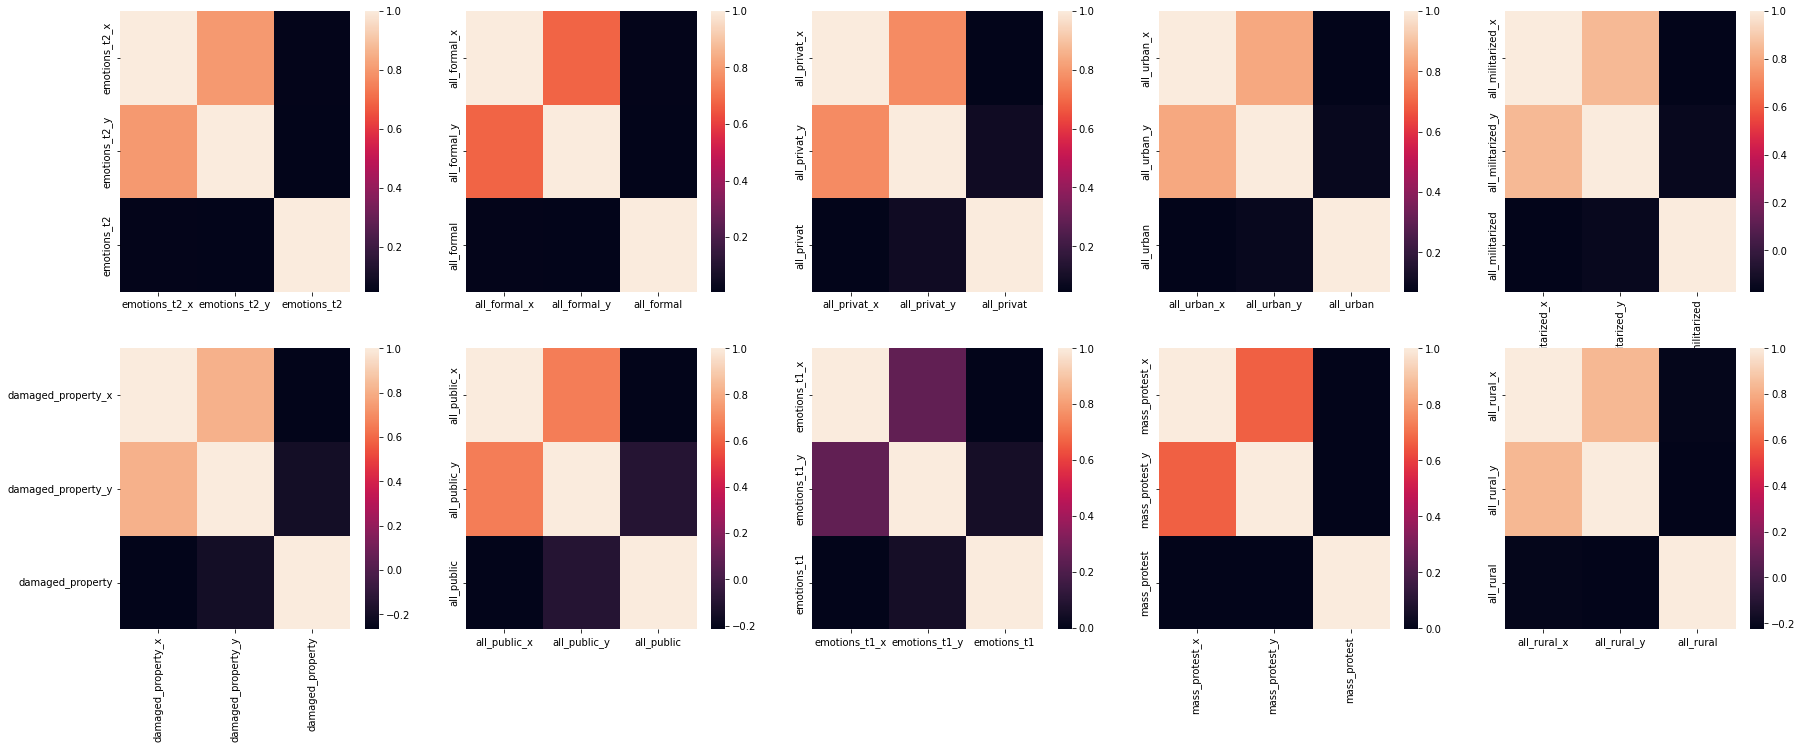

In [181]:
plt.figure(figsize=[30, 30])

for i, j in enumerate(swin_df.columns[1:]):
    
    plt.subplot(5,5, i+1)

    temp_df = pd.merge(swin_df[['img_id', j]], convnext_df[['img_id', j]], on='img_id')
    temp_df = pd.merge(temp_df, efficientnet_df[['img_id', j]], on='img_id')
    #temp_df

    sns.heatmap(temp_df.corr())
    
plt.show()

In [ ]:
for i in ['top', 'bottom']:
    loop_plot(convnext_df, 'convnext', sample = i)

In [ ]:
for i in ['top', 'bottom']:
    loop_plot(efficientnet_df, 'efficientnet', sample = i)

In [ ]:
for i in ['top', 'bottom']:
    loop_plot(swin_df, 'swin', sample = i)

In [175]:
new_df = pd.merge(swin_df, convnext_df, on = 'img_id', suffixes= ['_swin', '_convnext'])

for i in swin_df.columns[1:]:
    new_df[f'{i}_ens'] = (swin_df[i] + convnext_df[i])/2

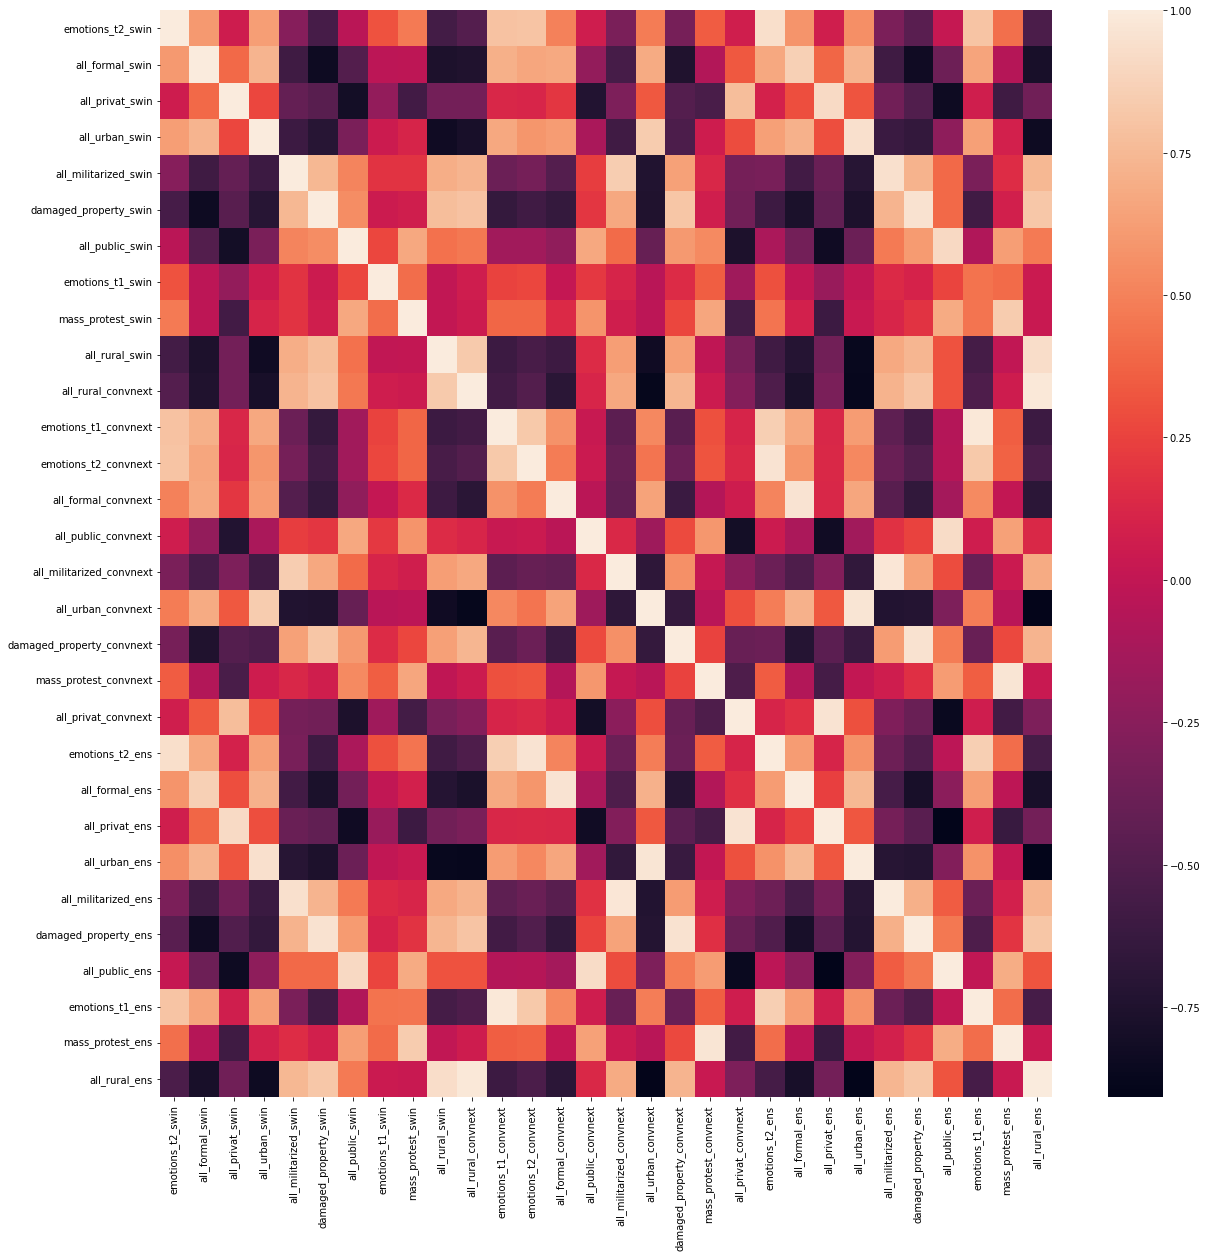

In [179]:
plt.figure(figsize=[20, 20])

sns.heatmap(new_df.corr())
plt.show()

In [ ]:
#new_df.to_pickle()

# NOW MERGE with bodies and save:

In [ ]:
data_dir = '/home/simon/Documents/Bodies/data/done_dfs/'

with open(f'{data_dir}bodies_df_2022_v1_2.pkl', 'rb') as file:
    bodies_df_exposure = pickle.load(file)

In [ ]:
bodies_df_exposure

In [ ]:
new_bodies = bodies_df_exposure.merge(convnext_df, on = 'img_id', how = 'left')
new_bodies.to_pickle(f"{data_dir}/bodies_df_2022_v1_2.pkl")  
new_bodies.to_csv(f"{data_dir}/bodies_df_2022_v1_2.csv")  